In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import Caretaker
from pyfoomb import Visualization

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


The toy example `SequentialKinetic` in Example01 will now be extended by events. The model will be modified in a way that the value of `k2` is set to zero before a certain timepoint `t_add`, where the catalyst is added that will enable the reaction B $\rightarrow$ C.

In [2]:
# Defines the model class
class SequentialKinetic_Variant01(BioprocessModel):
    
    # Note the new argument `sw` in the signature of method `rhs`
    def rhs(self, t, y, sw):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        A, B, C = y
        
        # Unpacks the model parameters.
        k1 = self.model_parameters['k1']
        
        # The `sw` (switches) argument represents a list of booleans, 
        # which are true after the corresponding event was hit (False -> True)
        if sw[0]:
            k2 = self.model_parameters['k2']
        else:
            k2 = 0
        
        # Defines the derivatives.
        dAdt = -k1*A
        dBdt = k1*A - k2*B
        dCdt = k2*B
        
        # Returns the derivatives.
        # The order corresponds to the state vector.
        return [dAdt, dBdt, dCdt]
    
    # Note that the `state_events` method has the same signature like the `rhs` method.
    def state_events(self, t, y, sw):
        
        # Unpacks the event parameters
        t_add = self.model_parameters['t_add']
        
        # This event is hit when this expression evaluates to zero.
        event_t = t_add - t 
        
        # Events must be returned as list or numpy array
        return [event_t]      
    
    
# Defines a dictionary for the initial values.
# The keys corresponds to the model states, extended by a 0 (zero).
initial_values = {
    'A0' : 50.0,
    'B0' : 0.0,
    'C0' : 0.0,
}

# Defines a dictionary for the model parameters
# The keys match those variable names used in the model class
model_parameters = {
    'k1' : 0.2,
    'k2' : 0.1,
    't_add' : 10.0,
}

In [3]:
# Instantiate a Caretaker, which manages the model and its parametrization.
caretaker = Caretaker(
    bioprocess_model_class=SequentialKinetic_Variant01, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

In [4]:
# Runs a forward simulation.
simulation = caretaker.simulate(t=24)

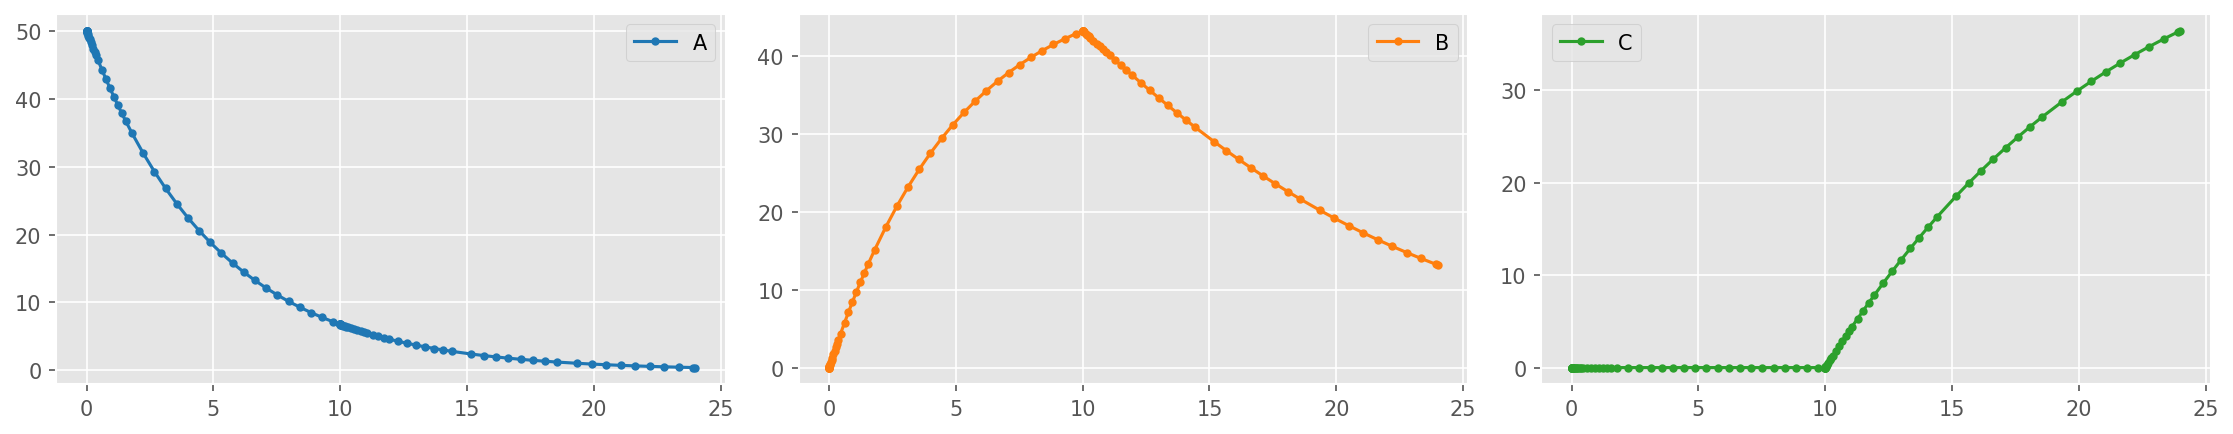

In [5]:
# Visualize the resulting trajectories
_ = Visualization.show_kinetic_data(simulation)

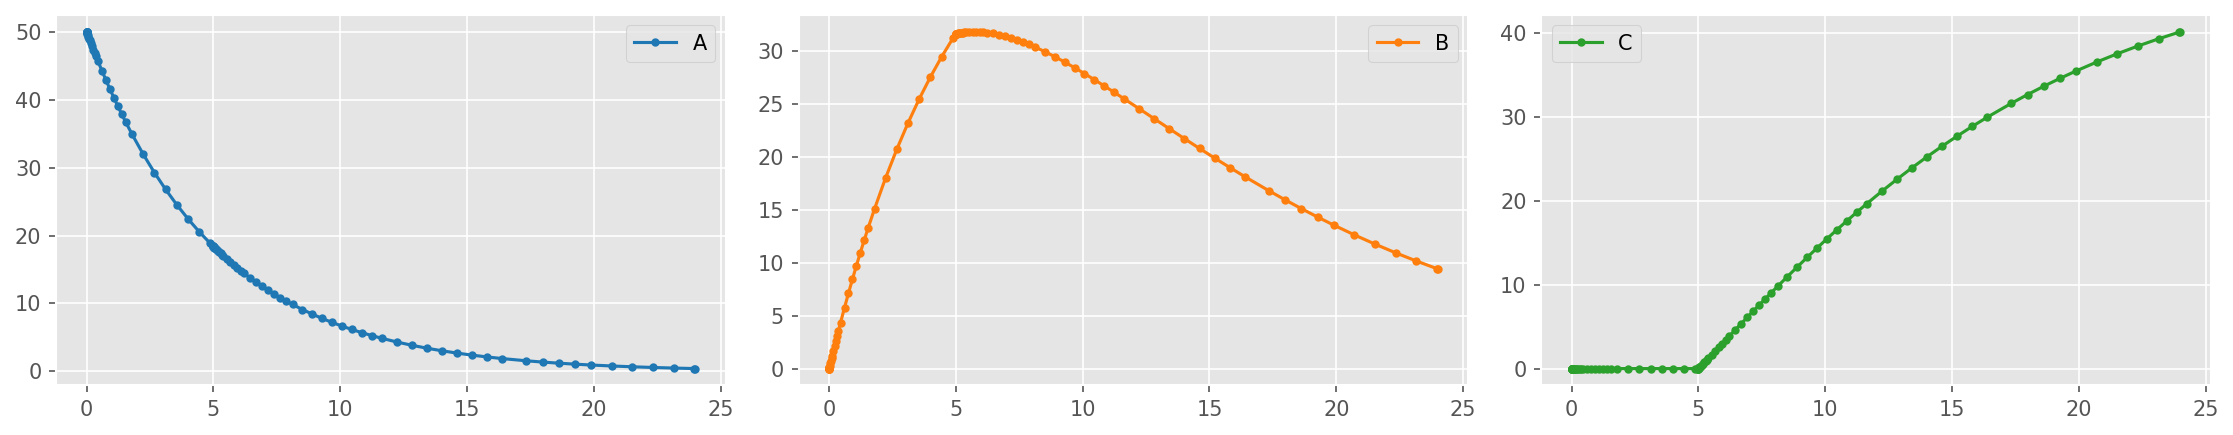

In [6]:
# One can run a forward simulation also for different, specific parameter values by using the `parameters` keyword.
simulation = caretaker.simulate(t=24, parameters={'t_add' : 5.0})
_ = Visualization.show_kinetic_data(simulation)

In [7]:
# This is easily verified by looking at the parameter mapping property of the caretaker
# NOTE: The replicate_id is `None`, indicating that a caretaker was used with only one, unnamed replicate
caretaker.parameter_mapping

,,local_name,value
global_name,replicate_id,,
A0,NaN,A0,50.0
B0,NaN,B0,0.0
C0,NaN,C0,0.0
k1,NaN,k1,0.2
k2,NaN,k2,0.1
t_add,NaN,t_add,10.0


Now we'll create a model with several events. The specification at which timepoint an event occurs is also referred to as explicit event. In contrast, an event timepoint can be implicitly defined by defining a corresponding value of a model state that has to be reached. Since the timepoint at which a certain model state reached a specified value is governed by the dynamics of the system, the corresponding time point is defined implicitly.

In [8]:
# Defines the model class
class SequentialKinetic_Variant02(BioprocessModel):
    
    # Note the new argument `sw` in the signature of method `rhs`
    def rhs(self, t, y, sw):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        A, B, C = y
        
        # Unpacks the model parameters.
        k1 = self.model_parameters['k1']
        
        # The `sw` (switches) argument represents a list of booleans, 
        # which are true after the corresponding event was hit (False -> True)
        if sw[0]:
            k2 = self.model_parameters['k2']
        else:
            k2 = 0
        
        # Defines the derivatives.
        dAdt = -k1*A
        dBdt = k1*A - k2*B
        dCdt = k2*B
        
        # Returns the derivatives as list
        # The order corresponds to the state vector.
        return [dAdt, dBdt, dCdt]
    
    # Note that the `state_events` method has the same signature like the `rhs` method.
    def state_events(self, t, y, sw):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        A, B, C = y
        
        # Unpacks the event parameters
        t_add = self.model_parameters['t_add']
        A_min = self.model_parameters['A_min']
        
        # This event is hit when this expression evaluates to zero.
        event_t = t_add - t 
        #This event is hit when the value of A equals A_min
        event_A = A_min - A
        
        # Events must be returned as list or numpy array
        return [event_t, event_A]    
    
    
    # This method modifies the values of the model states, 
    # so that the integration starts again, but with different initial values
    def change_states(self, t, y, sw):

        # Unpacks the state vector. The states are alphabetically ordered.
        A, B, C = y
        
        # In case the second event is hit, modify the state `A`
        if sw[1]:
            A_add = self.model_parameters['A_add']
            A = A + A_add
            
        return [A, B, C]
    
    
# Defines a dictionary for the initial values.
# The keys corresponds to the model states, extended by a 0 (zero).
initial_values = {
    'A0' : 50.0,
    'B0' : 0.0,
    'C0' : 0.0,
}

# Defines a dictionary for the model parameters
# The keys match those variable names used in the model class
model_parameters = {
    'k1' : 0.2,
    'k2' : 0.1,
    't_add' : 10.0,
    'A_min' : 10.0,
    'A_add' : 20.0,
}

In [9]:
# Instantiate a Caretaker, which manages the model and its parametrization.
caretaker = Caretaker(
    bioprocess_model_class=SequentialKinetic_Variant02, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

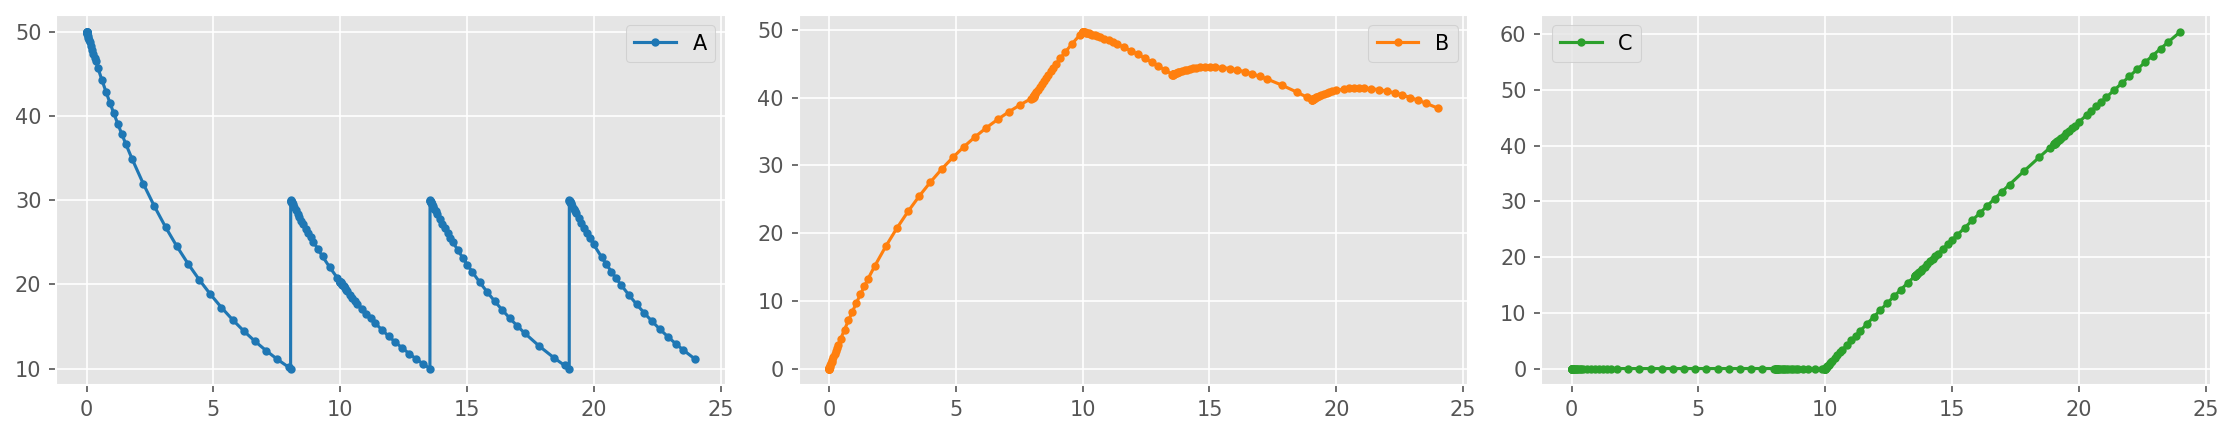

In [10]:
# Like before, runs a forward simulation and visualize the result
simulation = caretaker.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation)

As soon as state `A` reaches a value of 10 (i.e., `A_min`), the corresponding state is updated (`A = A + A_add`), resulting in an saw-tooth behavior of the system. In addition, at t=10 (i.e., `t_add`), the conversion B $\rightarrow$ C starts.